In [12]:
from IPython.display import display, HTML

CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

Sun - spacecraft connection in Python
---
Using

- *SunPy* for EUV and mangetic field data
- *HelioPy* spacecraft trajectory
- *pfsspy* for PFSS extrapolation

Import and loading SPICE kernels
---
- HelioPy can automatically find some SPICE kernels
- Support for loading custom SPICE files too

In [18]:
from heliopy import spice
from heliopy.data import spice as spicedata

spice.furnish(spicedata.get_kernel('psp'))
spice.furnish(spicedata.get_kernel('psp_pred'))

In [2]:
import astropy.coordinates as coord
from sunpy.coordinates import frames
def trajectory2skycoord(trajectory):
    skycoord = coord.SkyCoord(x=psp.x, y=psp.y, z=psp.z,
                          frame=frames.HeliographicCarrington,
                          representation_type='cartesian')
    skycoord.representation_type = 'spherical'
    return skycoord

Generate PSP trajectory
---
- Sample trajectory at custom dates

In [14]:
import astropy.units as u
from datetime import datetime, timedelta

psp = spice.Trajectory('SPP')
starttime = datetime(2018, 10, 31)
times = [starttime + timedelta(days=i) for i in range(18)]

# Use a non-inertial (Carrington) frame fixed with respect to the surface of the Sun
frame = 'IAU_SUN' 
psp.generate_positions(times, 'Sun', 'IAU_SUN')

# Take the PSP trajectory and put it into a coordinate system object
psp_sky_coord = trajectory2skycoord(psp)

Plot PSP trajectory
---

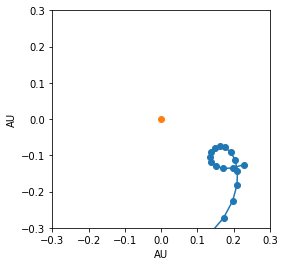

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_aspect('equal')

ax.plot(psp.x.to(u.au), psp.y.to(u.au), marker='o')
ax.plot(0, 0, marker='o', color='C1')

ax.set_xlim(-0.3, 0.3); ax.set_xlabel('AU');
ax.set_ylim(-0.3, 0.3); ax.set_ylabel('AU');

Trace longitude back along the Parker spiral
---

In [ ]:
import astropy.constants as const

omega_sun = 14.713 * u.deg / u.d
vsw = 300 * u.km / u.s
def delta_long(r):
    return omega_sun * (r - 2.5 * const.R_sun) / vsw

dlong = delta_long(psp_sky_coord.radius)
psp_solar_lon = psp_sky_coord.lon + dlong
psp_sky_coord = coord.SkyCoord(radius=psp_sky_coord.radius, lat=psp_sky_coord.lat,
                               lon=psp_solar_lon,
                               frame=frames.HeliographicCarrington,
                               representation_type='spherical')

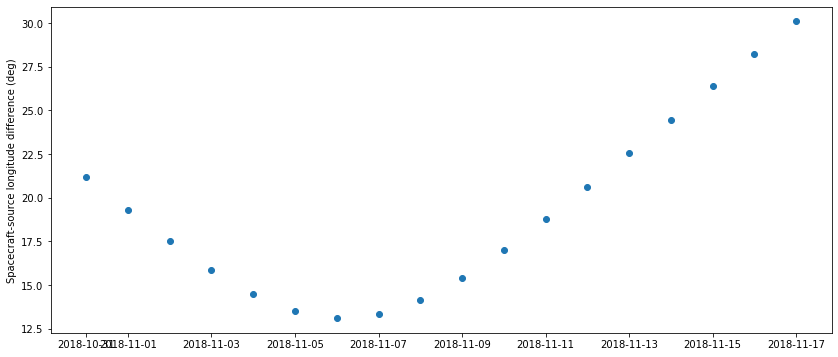

In [17]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot_date(psp.times, dlong.to(u.deg), marker='o')
ax.set_ylabel('Spacecraft-source longitude difference (deg)');

Import AIA map
----

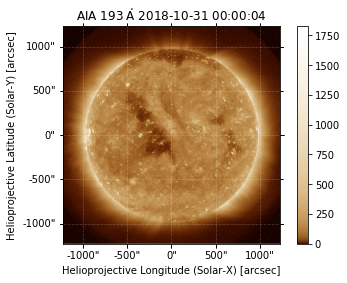

In [6]:
import sunpy.map
aia = sunpy.map.Map('AIA20181031_0000_0193.fits')
aia.peek()

Import GONG magnetic field map
---

In [7]:
import sunpy.io
# Use SunPy to read the .fits file with the data
[[data, header]] = sunpy.io.read_file('mrzqs181030t0014c2210_259.fits')
header['cunit1'] = 'arcsec'
header['cunit2'] = 'arcsec'
gong_map = sunpy.map.Map(data, header)

# Extract the data, and remove the mean to enforce div(B) = 0 on the solar
# surface
br = data
br = br - np.nanmean(br)
offset = 5
# GONG maps have their LH edge at -180deg, so roll to get it at 0deg
br = np.roll(br, header['CRVAL1'] + 180 + offset, axis=1)

Set up PFSS input
---

Text(0.5, 1.0, 'Input GONG map')

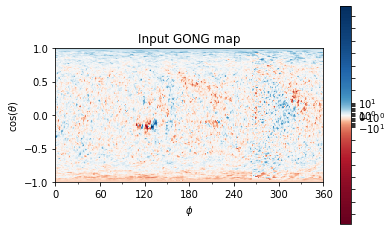

In [8]:
import pfsspy
nr = 60    # Number of radial model points
rss = 2.5  # Source surface radius

# Create PFSS input object
input = pfsspy.Input(br, nr, rss, dtime=aia.date)

# Plot input magnetic field
import matplotlib.colors as mcolor
fig, ax = plt.subplots()
mesh = input.plot_input(ax, norm=mcolor.SymLogNorm(5))
fig.colorbar(mesh)
ax.set_title('Input GONG map')

Calculate PFSS solution
---

In [9]:
output = pfsspy.pfss(input)

# Trace field lines through the solution
flines = []
psp_sky_coord.representation_type = 'cartesian'
for i in range(len(psp.x)):
    psp_coord = np.array([psp_sky_coord.x[i].value,
                          psp_sky_coord.y[i].value,
                          psp_sky_coord.z[i].value])
    psp_coord = psp_coord * 2.49 / np.linalg.norm(psp_coord)
    fline = output.trace(psp_coord,  atol=1e-8, rtol=1e-8)
    flines.append(fline)

Plot PFSS solution
---

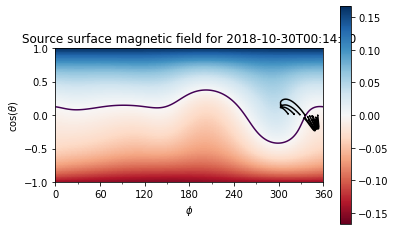

In [10]:
fig, ax = plt.subplots()
mesh = output.plot_source_surface(ax)
fig.colorbar(mesh)
ax.set_title('Source surface magnetic field for {}'.format(header['DATE']))
output.plot_pil(ax)
for fline in flines:
    fline.representation_type = 'spherical'
    ax.plot(fline.lon, np.sin(fline.lat), color='k')

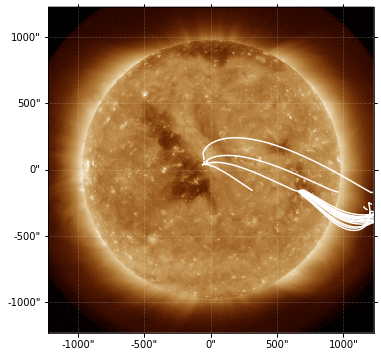

In [11]:
# Create a figure and plot AIA image
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1, projection=aia)
aia.plot(annotate=False, axes=ax, vmin=0)

# Plot field lines
for fline in flines:
    fline = fline.transform_to(aia.coordinate_frame)
    ax.plot(fline.Tx.to(u.deg), fline.Ty.to(u.deg),
            transform=ax.get_transform('world'),
            alpha=1, color='white')

ax.set_xlim(0, 1024);